In [1]:
%load_ext autoreload
%autoreload 2
from torch_geometric.data import Data, Batch
from ogb.utils.features import (atom_to_feature_vector,
 bond_to_feature_vector) 
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds
import numpy as np
import torch
import os 
import sys

In [2]:
def get_mol_objects(filename):
    mol_list = []
    energy_list = []
   # energies = 
    with open(filename, "r") as f:
        lines = f.readlines()
        file_str  = "".join(lines)
        atom_num = lines[0]
    xyz_list = file_str.split(atom_num)[1:]
    for i in range(len(xyz_list)):
        x = Chem.MolFromXYZBlock(f'{atom_num.strip()}\n' + xyz_list[i])
        Chem.rdDetermineBonds.DetermineConnectivity(x)
        energy = float(xyz_list[i].split('\n')[0].strip())
        energy_list.append(energy)
        mol_list.append(x)
    return mol_list, energy_list

In [3]:
import contextlib
import os
import re
import subprocess
import warnings

def _get_energy(file):
    normal_termination = False
    with open(file) as f:
        for l in f:
            if "TOTAL ENERGY" in l:
                try:
                    energy = float(re.search(r"[+-]?(?:\d*\.)?\d+", l).group())
                except:
                    return np.nan
            if "normal termination of xtb" in l:
                normal_termination = True
    if normal_termination:
        return energy
    else:
        return np.nan

def run_gfn_xtb(
    filepath,
    filename,
    gfn_version="gfnff",
    opt=False,
    gfn_xtb_config: str = None,
    remove_scratch=True,
):
    """
    Runs GFN_XTB/FF given a directory and either a coord file or all coord files will be run

    :param filepath: Directory containing the coord file
    :param filename: if given, the specific coord file to run
    :param gfn_version: GFN_xtb version (default is 2)
    :param opt: optimization or single point (default is opt)
    :param gfn_xtb_config: additional xtb config (default is None)
    :param remove_scratch: remove xtb files
    :return:
    """
    xyz_file = os.path.join(filepath, filename)

    # optimization vs single point
    if opt:
        opt = "--opt"
    else:
        opt = ""

    # cd to filepath
    starting_dir = os.getcwd()
    os.chdir(filepath)

    file_name = str(xyz_file.split(".")[0])
    cmd = "xtb --{} {} {} {}".format(
        str(gfn_version), xyz_file, opt, str(gfn_xtb_config or "")
    )

    # run XTB
    with open(file_name + ".out", "w") as fd:
        subprocess.run(cmd, shell=True, stdout=fd, stderr=subprocess.STDOUT)

    # check XTB results
    if os.path.isfile(os.path.join(filepath, "NOT_CONVERGED")):
        # optimization not converged
        warnings.warn(
            "xtb --{} for {} is not converged, using last optimized step instead; proceed with caution".format(
                str(gfn_version), file_name
            )
        )

        # remove files
        if remove_scratch:
            os.remove(os.path.join(filepath, "NOT_CONVERGED"))
            os.remove(os.path.join(filepath, "xtblast.xyz"))
            os.remove(os.path.join(filepath, file_name + ".out"))
        energy = np.nan

    elif opt and not os.path.isfile(os.path.join(filepath, "xtbopt.xyz")):
        # other abnormal optimization convergence
        warnings.warn(
            "xtb --{} for {} abnormal termination, likely scf issues, using initial geometry instead; proceed with caution".format(
                str(gfn_version), file_name
            )
        )
        if remove_scratch:
            os.remove(os.path.join(filepath, file_name + ".out"))
        energy = np.nan

    else:
        # normal convergence
        # get energy
        energy = _get_energy(file_name + ".out")
        if remove_scratch:
            with contextlib.suppress(FileNotFoundError):
                os.remove(os.path.join(filepath, file_name + ".out"))
                os.remove(os.path.join(filepath, "gfnff_charges"))
                os.remove(os.path.join(filepath, "gfnff_adjacency"))
                os.remove(os.path.join(filepath, "gfnff_topo"))
                os.remove(os.path.join(filepath, "xtbopt.log"))
                os.remove(os.path.join(filepath, "xtbopt.xyz"))
                os.remove(os.path.join(filepath, "xtbtopo.mol"))
                os.remove(os.path.join(filepath, "wbo"))
                os.remove(os.path.join(filepath, "charges"))
                os.remove(os.path.join(filepath, "xtbrestart"))
    os.chdir(starting_dir)
    return energy

In [4]:
def get_mol_path(mol_idx, solvation=False):
    if solvation:
        return os.path.join(os.getcwd(), 'conformers', f'molecule_{mol_idx}', 'solvation')
    else:
        return os.path.join(os.getcwd(), 'conformers', f'molecule_{mol_idx}', 'vacuum')
get_mol_path(0)

'/home/radoslavralev/Documents/Thesis/gfn-diffusion/energy_sampling/notebooks/conformers/molecule_0/vacuum'

In [5]:
torch.ones(32, 69).reshape(-1, 23, 3).shape

torch.Size([32, 23, 3])

In [6]:
def xyz_mol2graph(xyz_mol):
    """
    Converts SMILES string to graph Data object
    :input: SMILES string (str)
    :return: graph object
    """

    mol = xyz_mol
    pos = mol.GetConformer().GetPositions()
    mol = Chem.AddHs(mol)
    #print(mol)
    # atoms
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_features_list.append([atom.GetAtomicNum()])
    x = np.array(atom_features_list, dtype = np.int64)

    # bonds
    num_bond_features = 3  # bond type, bond stereo, is_conjugated
    if len(mol.GetBonds()) > 0: # mol has bonds
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()

            edge_feature = bond_to_feature_vector(bond)

            # add edges in both directions
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
        edge_index = np.array(edges_list, dtype = np.int64).T

        # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        edge_attr = np.array(edge_features_list, dtype = np.int64)

    else:   # mol has no bonds
        print('Mol has no bonds :()')
        edge_index = np.empty((2, 0), dtype = np.int64)
        edge_attr = np.empty((0, num_bond_features), dtype = np.int64)

    graph = dict()
    graph['edge_index'] = edge_index
    graph['edge_feat'] = edge_attr
    graph['node_feat'] = x
    graph['pos'] = pos
    graph['num_nodes'] = len(x)

    return graph 

In [7]:
def prep_input(graph, pos=None, device=None):
    datalist = []
    for xyz in pos:
        if pos is not None:
            graph['pos'] = xyz  
        #print('Number of atoms:', graph['node_feat'].shape[0])
        data = Data(
            atoms=torch.from_numpy(graph['node_feat'][:, 0]), 
            edge_index=torch.from_numpy(graph['edge_index']), 
            edge_attr=torch.from_numpy(graph['edge_feat']), 
            pos=graph['pos'],).to(device)
        data.validate(raise_on_error=True)
        datalist.append(data)
    #batch = Batch.from_data_list(datalist).to(device)
    return datalist

In [8]:
def extract_graphs(filename):
    mol_objects, mol_ens = get_mol_objects(filename)
    datalist = []
    for mol, en in zip(mol_objects, mol_ens):
        graph = xyz_mol2graph(mol)
        data = Data(
            atoms=torch.from_numpy(graph['node_feat'][:, 0]), 
            edge_index=torch.from_numpy(graph['edge_index']), 
            edge_attr=torch.from_numpy(graph['edge_feat']), 
            pos=torch.from_numpy(graph['pos']),
            y=torch.tensor(en))
        data.validate(raise_on_error=True)
        datalist.append(data)
    return datalist

In [9]:
# calculate free energy for all pairs of conformers

def solvation_en(index=0):
    solvent_dir = os.path.join('../..', 'conformation_sampling', 'conformers', f'molecule_{index}', 'solvation', 'crest_conformers.xyz')
    vacuum_dir = os.path.join('../..', 'conformation_sampling', 'conformers', f'molecule_{index}', 'vacuum', 'crest_conformers.xyz')
    _, solv_en = get_mol_objects(solvent_dir)
    _, vac_en = get_mol_objects(vacuum_dir)
    #print(solv_en, vac_en)
    # avg_solv_en = np.mean(np.exp(np.array(solv_en)))
    # avg_vac_en = np.mean(np.exp(np.array(vac_en))) 
    # free_en = avg_vac_en - avg_solv_en
    l = min(len(solv_en), len(vac_en))
    free_en = -1/627.583*np.logaddexp.reduce(-(np.array(solv_en[:l])-np.array(vac_en[:l])) * 627.503) - np.log(l)
    return free_en
    
for i in range(600):
    free_en = solvation_en(i)
    if free_en:
        print(free_en)
    if i == 10:
        break
    
    

-5.070985140121123
-2.717450109829989
-0.7029199965511594
-1.9523127350697063
-0.700240312316485
-3.3073722504625738
-0.003604080517829243
-0.0033940972884697737
-1.7962577726122022
-2.7146895664696427
-3.6762836631174647


In [10]:
solvent_data = []
vacuum_data = []
for dir in os.listdir(os.path.join(os.getcwd(),'..', '..', 'conformation_sampling', 'conformers')):
    solvent_dir = os.path.join(os.getcwd(), '..', '..','conformation_sampling', 'conformers', dir, 'solvation', 'crest_conformers.xyz')
    vacuum_dir = os.path.join(os.getcwd(),'..', '..','conformation_sampling', 'conformers', dir, 'vacuum', 'crest_conformers.xyz')
    solvent_graphs = extract_graphs(solvent_dir)
    vacuum_graphs = extract_graphs(vacuum_dir)
    solvent_data.extend(solvent_graphs)
    vacuum_data.extend(vacuum_graphs)
    # break

In [11]:
len(solvent_data[:11365])

11365

In [12]:
# find max number of atoms in a molecule
max_atomic_el = 0
for i, data in enumerate(solvent_data):
    if data.atoms.max() > max_atomic_el:
        max_atomic_el = data.atoms.max()
        print(i, max_atomic_el)

0 tensor(8)
684 tensor(17)
689 tensor(53)


In [13]:
from torch_geometric import loader

train_dataloade_solv = loader.DataLoader(solvent_data[5000:], batch_size=32, shuffle=True)
train_dataloade_vac = loader.DataLoader(vacuum_data[5000:], batch_size=32, shuffle=True)
test_dataloade_solv = loader.DataLoader(solvent_data[:5000], batch_size=32, shuffle=True)
test_dataloade_vac = loader.DataLoader(vacuum_data[:5000], batch_size=32, shuffle=True)

In [14]:
for data in train_dataloade_solv:
    print(data)
    break

DataBatch(edge_index=[2, 1892], edge_attr=[1892, 3], y=[32], pos=[970, 3], atoms=[970], batch=[970], ptr=[33])


In [15]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm.notebook import tqdm
import time

def update_plot(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.yscale('log')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()  # Close the figure to prevent it from being displayed again

In [16]:
def train_model(model_type, in_dim, out_dim, emb_dim, num_layers, lr, epochs, dataloader, device, patience):
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
    from models.egnn import EGNNModel
    from models.mace import MACEModel
    import torch
    from tqdm import tqdm
    import numpy as np

    # Define the model
    if model_type == 'mace':
        model = MACEModel(in_dim=in_dim, out_dim=out_dim, emb_dim=emb_dim, num_layers=num_layers, equivariant_pred=False, batch_norm=False).to(device, dtype=torch.float64)
    elif model_type == 'egnn':
        model = EGNNModel(in_dim=in_dim, out_dim=out_dim, emb_dim=emb_dim, num_layers=num_layers, equivariant_pred=False).to(device, dtype=torch.float64)
    else:
        raise ValueError("Invalid model type. Choose either 'mace' or 'egnn'.")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience//2, factor=0.5, verbose=True)
    all_losses = []
    best_loss = np.inf
    best_epoch = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        running_loss = 0.0
        with tqdm(dataloader, unit="batch") as tepoch:
            for x in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                x = x.to(device)
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(x)
                loss = criterion(outputs.squeeze(), x.y.to(torch.float64).squeeze())

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update running loss
                running_loss += loss.item()
                all_losses.append(loss.item())

                if len(all_losses) % int((len(dataloader)/4)) == 0:
                    update_plot(all_losses[200:])

                tepoch.set_postfix(loss=loss.item() * 627.503)

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")

        # Step the scheduler
        scheduler.step(avg_loss)

        # Check for early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_epoch = epoch
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Best model from epoch {best_epoch+1} with loss {best_loss}")

    return model, all_losses
def eval_model(model, dataloader, device):
    model.eval()
    criterion = torch.nn.MSELoss()
    running_loss = 0.0
    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            outputs = model(x)
            loss = criterion(outputs.squeeze(), x.y.to(torch.float64).squeeze())
            running_loss += loss.item()
    return running_loss/len(dataloader)

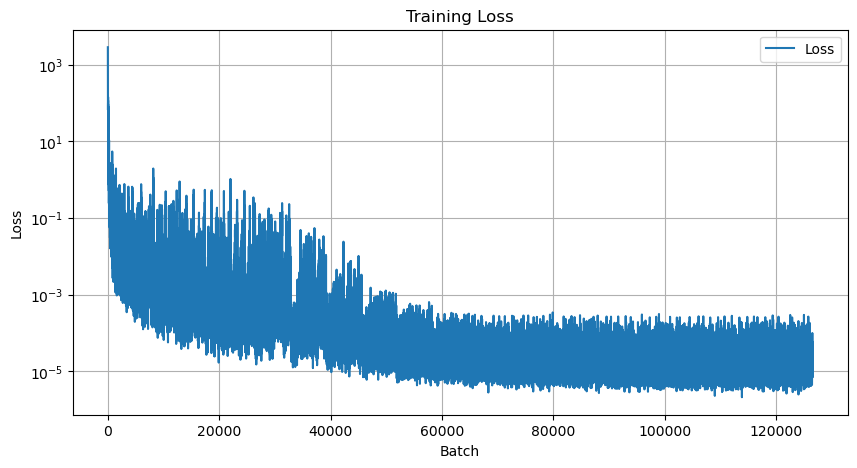

In [23]:
model, losses = train_model('egnn', in_dim=max_atomic_el+1, out_dim=1, emb_dim=32, num_layers=2, lr=0.001, epochs=100, dataloader=train_dataloade_solv, device='cuda', patience=6)
update_plot(losses)
clear_output(wait=True)

In [18]:
eval_model(model, train_dataloade_solv, 'cuda') * 627.503

0.014348658987106884

In [19]:
eval_model(model, test_dataloade_solv, 'cuda') * 627.503

0.03267495242453754

In [20]:
#print number of parameters
sum(p.numel() for p in model.parameters())

18243

In [25]:
# save model
torch.save(model.state_dict(), '../weights/egnn_solvation_batch_size_32.pt')

In [26]:
# save all model parameters in a json in the same folder
import json
model_params = {
    'in_dim': max_atomic_el.item()+1,
    'out_dim': 1,
    'emb_dim': 32,
    'num_layers': 2,
    'lr': 0.0001,
    'epochs': 100,
    'patience': 5,
    'batch_size': 32
}
with open('../weights/egnn_solvation_batch_size_32.json', 'w') as f:
    json.dump(model_params, f)